In [128]:
from datasets import load_dataset
import torch
import os
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
from datasets import load_dataset, ClassLabel, load_from_disk
from transformers import AutoModelForAudioClassification
import librosa
import IPython.display as ipd
from ipywebrtc import AudioRecorder, CameraStream
import plotly.graph_objects as go

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = load_dataset("myleslinder/crema-d", trust_remote_code=True, split='train')

id2label = {'0':'neutral', '1': 'happy','2': 'sad', '3': 'anger', '4': 'fear', '5': 'disgust'}
emotions = ['neutral', 'happy', 'sad', 'anger', 'fear', 'disgust']

label2id = dict()
for i in id2label:
    label2id[id2label[str(i)]] = str(i)

dataset = dataset.select_columns(['audio', 'label']) #This is simple classifcation task, whisper is already trained so no need for sentence.
dataset = dataset.train_test_split(test_size=0.3)


model_id = "distil-whisper/distil-medium.en"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id, do_normalize=True)

max_duration = 30.0

if os.path.exists("vector.hf"):
    vectorized_dataset = load_from_disk("vector.hf")
else:
    max_duration = 30.0
    def process(ds):
        audio_arrays = [x["array"] for x in ds["audio"]]
        inputs = feature_extractor( #pass into whisper model
            audio_arrays,
            sampling_rate=feature_extractor.sampling_rate, #set to predetermined 16k Hz
            max_length=int(feature_extractor.sampling_rate * max_duration), #find the longest clip (this should be adjusted if dataset includes extremely long clips)
            truncation=True,
        )
        return inputs
    vectorized_dataset = dataset.map(process, remove_columns="audio", batched=True, batch_size=16, num_proc=1,)
    vectorized_dataset.save_to_disk("vector.hf")
    
vectorized_dataset.set_format("torch")
vectorized_dataset = vectorized_dataset.rename_column("label", "labels")

test_dataset = vectorized_dataset["test"]

BATCH_SIZE=1

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
)
model.to(device)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()



Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at distil-whisper/distil-medium.en and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1024)
    (layers): ModuleList(
      (0-23): 24 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05

In [129]:
def plot_emotion_probabilities(probabilities, emotions):
    """
    Plots the emotion classification probabilities using Plotly.

    Parameters:
    - probabilities: List of probabilities for each emotion.
    - emotions: List of emotion labels corresponding to the probabilities.

    Returns:
    - A Plotly bar chart showing the probabilities of each emotion.
    """
    # Format probabilities as percentages for display
    formatted_probabilities = [f'{p:.2%}' for p in probabilities]

    # Create a bar chart
    fig = go.Figure(
        data=[go.Bar(x=emotions, y=probabilities, text=formatted_probabilities, textposition='auto')]
    )

    # Customize layout
    fig.update_layout(
        title='Emotion Classification Probabilities',
        xaxis_title='Emotions',
        yaxis_title='Probability',
        yaxis=dict(tickformat=".0%"),
        bargap=0.2
    )

    # Show the figure
    fig.show()


In [22]:
# for i in range(len(test_dataset)):
for i in range(3):
    batch = {k: v.to(device) for k, v in test_dataset[i].items()}
    print(batch)
    output_seq = model(**batch)
    output_tensor = output_seq[1].argmax(dim=1)
    print(output_tensor)
    print(test_dataset[i]['labels'], dataset['test']['label'][i])
    ipd.display(ipd.Audio(dataset['test']['audio'][i]['path']))

{'labels': tensor(4, device='cuda:0'), 'input_features': tensor([[ 0.3401, -0.0746,  0.1025,  ..., -0.6078, -0.6078, -0.6078],
        [ 0.3825,  0.1835,  0.3488,  ..., -0.6078, -0.6078, -0.6078],
        [ 0.3196,  0.3807,  0.4688,  ..., -0.6078, -0.6078, -0.6078],
        ...,
        [-0.6078, -0.5529, -0.4900,  ..., -0.6078, -0.6078, -0.6078],
        [-0.6014, -0.5669, -0.4720,  ..., -0.6078, -0.6078, -0.6078],
        [-0.5699, -0.4988, -0.5101,  ..., -0.6078, -0.6078, -0.6078]],
       device='cuda:0')}


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [127]:
# for i, batch in enumerate(test_dataloader):
#     batch = {k: v.to(device) for k, v in batch.items()}
#     batch['labels'] = torch.tensor([0]).to(device)
#     # print(batch)
#     output_seq = model(**batch)
#     output_tensor = output_seq[1].argmax(dim=1)
#     print("Prediction: ", id2label[str(int(output_tensor)))
#     print(id2label[str(int(test_dataset[i]['labels']))], id2label[str(dataset['test']['label'][i])])
#     ipd.display(ipd.Audio(dataset['test']['audio'][i]['path']))
#     if i>5:
#         break

In [143]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

/var/folders/pq/1v9znmkd0bz24_nh_cpqjp9c0000gn/T/ipykernel_43427/3950758787.py:4: UserWarning:

PySoundFile failed. Trying audioread instead.

/Users/rohan/miniforge3/envs/DeepLearning/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.



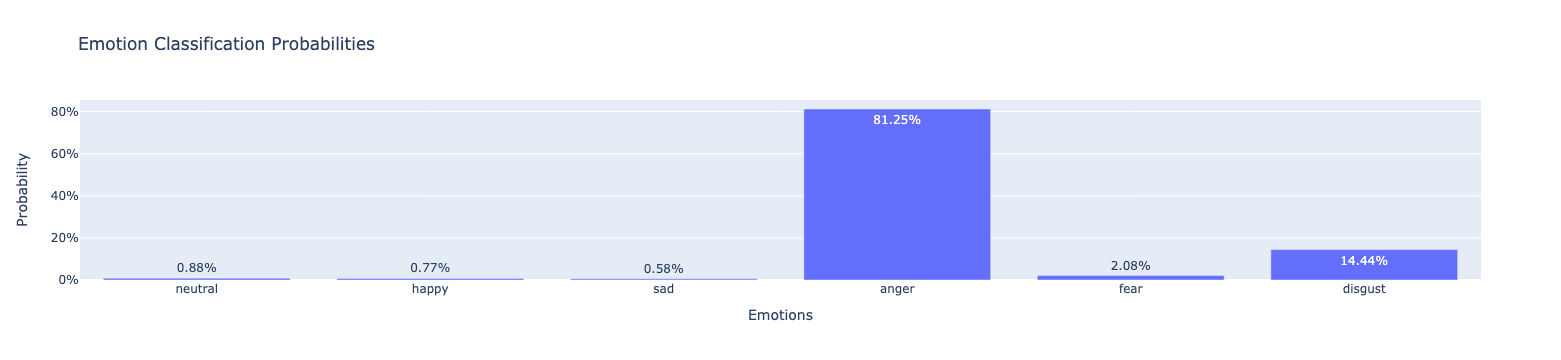

In [144]:
softmax = torch.nn.Softmax(-1)
audio_path = "recording_iter.wav"
recorder.save(audio_path)
audio_input, sample_rate = librosa.load(audio_path, sr=16000)
input_values = feature_extractor(audio_input, sampling_rate=sample_rate, return_tensors="pt")
input_values['labels'] = torch.tensor([0])
logits = model(**input_values)['logits']
probabilities = softmax(logits).tolist()[0]
plot_emotion_probabilities(probabilities, emotions)